# Project 3: Web APIs & NLP

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# import libraries for modelling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

# metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report, plot_roc_curve, roc_curve, auc

tvec = TfidfVectorizer()
cvec = CountVectorizer()

## Read csv file

In [2]:
reddit_post = pd.read_csv("../datasets/cleaned_reddit_post.csv") # read csv file

print(reddit_post.shape)
reddit_post.head()

(8260, 8)


,title,subreddit,target,char_count,word_count,processed_title,no_stopword_title,processed_wordcount
0,Surgeon Kind Of Pissed Patient Seeing Her Defo...,TheOnion,0,109,19,surgeon kind of pissed patient seeing her defo...,surgeon kind pissed patient seeing deformed fa...,19
1,McDonald’s blocked from building drive-through...,TheOnion,0,83,11,mcdonald s blocked from building drive through...,mcdonald blocked building drive rome ancient b...,14
2,Gwyneth Paltrow Touts New Diamond-Encrusted Tr...,TheOnion,0,89,11,gwyneth paltrow tout new diamond encrusted tre...,gwyneth paltrow tout new diamond encrusted tre...,12
3,Artist Crafting Music Box Hopes It Delights At...,TheOnion,0,81,13,artist crafting music box hope it delight at l...,artist crafting music box hope delight least o...,14
4,Homeowner Trying To Smoke Out Snakes Accidenta...,TheOnion,0,66,10,homeowner trying to smoke out snake accidental...,homeowner trying smoke snake accidentally burn...,10


In [3]:
reddit_post.dtypes

title                  object
subreddit              object
target                  int64
char_count              int64
word_count              int64
processed_title        object
no_stopword_title      object
processed_wordcount     int64
dtype: object

In [4]:
reddit_post.describe()

,target,char_count,word_count,processed_wordcount
count,8260.000000,8260.000000,8260.000000,8260.000000
mean,0.438499,78.553511,12.813317,13.256901
std,0.496233,31.376573,5.393535,5.591893
min,0.000000,9.000000,3.000000,3.000000
25%,0.000000,59.000000,9.000000,10.000000
50%,0.000000,76.000000,12.000000,13.000000
75%,1.000000,94.000000,15.000000,16.000000
max,1.000000,303.000000,54.000000,54.000000


## 03 Building Model

### Train Test Split


In [5]:
X = reddit_post['processed_title']
y = reddit_post['target']

In [6]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=42)

#### Top word for train_df

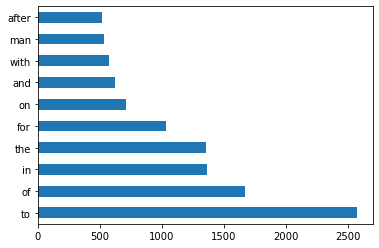

In [7]:
# Top word
# convert training data to dataframe
X_train_word = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
X_train_word.sum().sort_values(ascending=False).head(10).plot(kind='barh');

### Baseline score

In [8]:
y_test.value_counts(normalize=True)

0    0.561743
1    0.438257
Name: target, dtype: float64

### Compare CountVectorizer vs TF-IDF Vectorizer and use gridsearchcv to find best params for vectorizer

### MultinomialNB model w CountVectorizer

In [9]:
# setup pipeline

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [10]:
# setup hyperparameters for countvectorizer

pipe_params = {
    'cvec__max_features': [None,1000, 2000, 3000],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [0, 1],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2),(2,2)]
}

In [11]:
# Instantiate GridSearchCV

gs_cvec = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)

In [12]:
# Fit GridSearch to training data.
gs_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [None, 1000, 2000, 3000],
                         'cvec__min_df': [0, 1],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None, 'english']})

In [13]:
gs_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [14]:
# Get Predictions
predict_cvec = gs_cvec.predict(X_test)

# Save into confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict_cvec).ravel()
print(tn, fp, fn, tp)

1030 130 232 673


In [15]:
# create function to obtain model score
def get_score(model,Xtrain,ytrain, Xtest, ytest, predict):
    print('Model:', model.estimator )
    print('Gridsearch best score:', model.best_score_)
    print('Training set score:', model.score(Xtrain, ytrain))
    print('Testing set score:', model.score(Xtest, ytest))
    print('f1 score:', f1_score(ytest, predict))

In [16]:
get_score(gs_cvec,X_train,y_train,X_test,y_test,predict_cvec)

Model: Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])
Gridsearch best score: 0.8264729620661824
Training set score: 0.9917675544794189
Testing set score: 0.8246973365617434
f1 score: 0.788056206088993


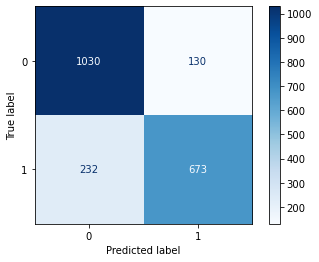

In [17]:
# View confusion matrix
plot_confusion_matrix(gs_cvec, X_test, y_test, cmap='Blues', values_format='d')

### MultinomialNB model + TF-IDF Vectorizer

In [18]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [19]:
# Search over hyperparameters
pipe_tvec_params = {
    'tvec__max_features': [None, 1000, 2000, 3000],
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [0, 1],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)]
}

In [20]:
# Instantiate GridSearchCV

gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params,
                        cv=5)

In [21]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [None, 1000, 2000, 3000],
                         'tvec__min_df': [0, 1],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [22]:
gs_tvec.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [23]:
# Get Predictions
predict_tvec = gs_tvec.predict(X_test)

# Save into confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict_tvec).ravel()
print(tn, fp, fn, tp)

1070 90 315 590


In [24]:
get_score(gs_tvec,X_train,y_train,X_test,y_test,predict_tvec)

Model: Pipeline(steps=[('tvec', TfidfVectorizer()), ('nb', MultinomialNB())])
Gridsearch best score: 0.8040355125100888
Training set score: 0.9862792574656981
Testing set score: 0.8038740920096852
f1 score: 0.7444794952681388


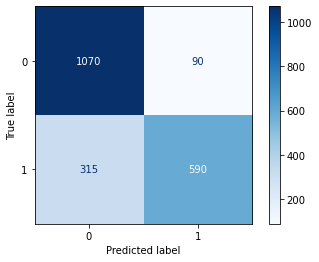

In [25]:
# View confusion matrix
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d')

**Comments:** Count vectorizer has higher train and test score compared to TF-IDF vectorizer. Countvectorizer seems to be the better vectorizer over TF-IDF vectorizer. The best parameters for countvectorizer is </br>{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}<br>
 Countvectorizer will be used for modelling and the tuned parameters will be used to build the models. 

## Create model

RandomForest, MultinomialNB, Logistic regression, K-Nearest Neighbors, SVM will be used for predicting a specific classification based on a set of parameters.

### Random Forests + count Vectorizer

In [26]:
rf = RandomForestClassifier()

In [27]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words= None, ngram_range=(1, 2), min_df = 0, max_df=0.9)),
    ('rf', RandomForestClassifier())
])

In [28]:
pipe_cvec_rf.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
  ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2)),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split

In [29]:
pipe_cvec_rf_params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3],
}

In [30]:
# Instantiate GridSearchCV

rf_cvec = GridSearchCV(pipe_cvec_rf, 
                        param_grid = pipe_cvec_rf_params,
                        cv=5)


In [31]:
# Fit GridSearch to training data.
rf_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_df=0.9, min_df=0,
                                                        ngram_range=(1, 2))),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 1, 2, 3],
                         'rf__n_estimators': [100, 150, 200]})

In [32]:
rf_cvec.best_params_

{'rf__max_depth': None, 'rf__n_estimators': 200}

In [33]:
# Get Predictions
predict_rf = rf_cvec.predict(X_test)

# Save into confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict_rf).ravel()
print(tn, fp, fn, tp)

1103 57 416 489


In [34]:
get_score(rf_cvec,X_train,y_train,X_test,y_test, predict_rf)

Model: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())])
Gridsearch best score: 0.7691686844229217
Training set score: 0.9996771589991928
Testing set score: 0.7709443099273607
f1 score: 0.6740179186767747


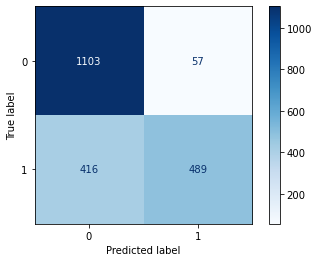

In [35]:
# View confusion matrix
plot_confusion_matrix(rf_cvec, X_test, y_test, cmap='Blues', values_format='d')

### MultinomialNB + count Vectorizer

In [36]:
pipe_cvec_mnb = Pipeline([
    ('cvec', CountVectorizer(stop_words= None, ngram_range=(1, 2), min_df = 0, max_df=0.9)),
    ('mnb',  MultinomialNB())
])

In [37]:
pipe_cvec_mnb.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
  ('mnb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2)),
 'mnb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'mnb__alpha': 1.0,
 'mnb__class_prior': None,
 'mnb__fit_prior': True}

In [38]:
pipe_cvec_mnb_params = {
    'mnb__alpha': np.linspace(0.5, 1.5, 6),
    'mnb__fit_prior': [True, False]
}

In [39]:
# Instantiate GridSearchCV

mnb_cvec = GridSearchCV(pipe_cvec_mnb, 
                        param_grid = pipe_cvec_mnb_params,
                        cv=5)


In [40]:
# Fit GridSearch to training data.
mnb_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_df=0.9, min_df=0,
                                                        ngram_range=(1, 2))),
                                       ('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'mnb__fit_prior': [True, False]})

In [41]:
mnb_cvec.best_params_

{'mnb__alpha': 1.1, 'mnb__fit_prior': False}

In [42]:
# Get Predictions
predict_mnb = mnb_cvec.predict(X_test)

# Save into confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict_mnb).ravel()
print(tn, fp, fn, tp)

1019 141 221 684


In [43]:
get_score(mnb_cvec,X_train,y_train,X_test,y_test,predict_mnb)

Model: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
                ('mnb', MultinomialNB())])
Gridsearch best score: 0.8272800645682002
Training set score: 0.9912832929782083
Testing set score: 0.8246973365617434
f1 score: 0.7907514450867053


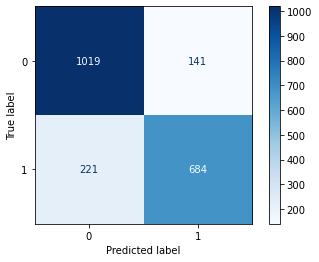

In [44]:
# View confusion matrix
plot_confusion_matrix(mnb_cvec, X_test, y_test, cmap='Blues', values_format='d')

### Logistic Regression + TF-IDF Vectorizer

In [45]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words= None, ngram_range=(1, 2), min_df = 0, max_df=0.9)),
    ('lr', LogisticRegression())
])

In [46]:
pipe_lr.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
  ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2)),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver'

In [47]:
# Search over hyperparameters
pipe_lr_params = {
    'lr__C': np.linspace(0.5, 2, 5),
    'lr__fit_intercept': [True,False],
}

In [48]:
# Instantiate GridSearchCV

lr_cvec = GridSearchCV(pipe_lr, 
                        param_grid = pipe_lr_params,
                        cv=5)

In [49]:
# Fit GridSearch to training data.
lr_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_df=0.9, min_df=0,
                                                        ngram_range=(1, 2))),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': array([0.5  , 0.875, 1.25 , 1.625, 2.   ]),
                         'lr__fit_intercept': [True, False]})

In [50]:
lr_cvec.best_params_

{'lr__C': 2.0, 'lr__fit_intercept': False}

In [51]:
# Get Predictions
predict_lr = lr_cvec.predict(X_test)

# Save into confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict_lr).ravel()
print(tn, fp, fn, tp)

994 166 180 725


In [52]:
get_score(lr_cvec,X_train,y_train,X_test,y_test,predict_lr)

Model: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
                ('lr', LogisticRegression())])
Gridsearch best score: 0.8163034705407586
Training set score: 0.9996771589991928
Testing set score: 0.8324455205811138
f1 score: 0.8073496659242763


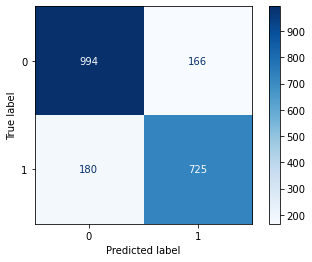

In [53]:
# View confusion matrix
plot_confusion_matrix(lr_cvec, X_test, y_test, cmap='Blues', values_format='d')

### KNN + count Vectorizer

In [54]:
pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer(stop_words= None, ngram_range=(1, 2), min_df = 0, max_df=0.9)),
    ('knn', KNeighborsClassifier())
])

In [55]:
pipe_cvec_knn.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
  ('knn', KNeighborsClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2)),
 'knn': KNeighborsClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [56]:
# Search over hyperparameters
pipe_cvec_knn_params = {
     #'knn__leaf_size': list(range(1,30,5)),
   'knn__n_neighbors': list(range(1,20,5)),
    'knn__p': [1,2]
}

In [57]:
# Instantiate GridSearchCV

knn_cvec = GridSearchCV(pipe_cvec_knn, 
                        param_grid = pipe_cvec_knn_params,
                        cv=5)

In [58]:
# Fit GridSearch to training data.
knn_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_df=0.9, min_df=0,
                                                        ngram_range=(1, 2))),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 6, 11, 16], 'knn__p': [1, 2]})

In [59]:
knn_cvec.best_params_

{'knn__n_neighbors': 1, 'knn__p': 2}

In [60]:
# Get Predictions
predict_knn = knn_cvec.predict(X_test)

# Save into confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict_knn).ravel()
print(tn, fp, fn, tp)

1135 25 636 269


In [61]:
get_score(knn_cvec,X_train,y_train,X_test,y_test,predict_knn)

Model: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
                ('knn', KNeighborsClassifier())])
Gridsearch best score: 0.6603712671509281
Training set score: 0.9996771589991928
Testing set score: 0.6799031476997579
f1 score: 0.44870725604670564


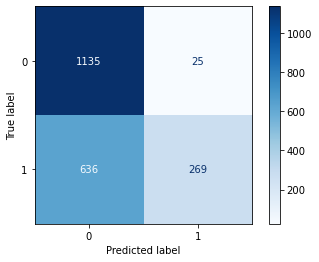

In [62]:
# View confusion matrix
plot_confusion_matrix(knn_cvec, X_test, y_test, cmap='Blues', values_format='d')

### SVM + CountVectorizer

In [63]:
pipe_svm = Pipeline([
    ('cvec', CountVectorizer(stop_words= None, ngram_range=(1, 2), min_df = 0, max_df=0.9)),
    ('svm', SVC())
])

In [64]:
pipe_svm.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
  ('svm', SVC())],
 'verbose': False,
 'cvec': CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2)),
 'svm': SVC(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'svm__C': 1.0,
 'svm__break_ties': False,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': 'ovr',
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf',
 'svm__max_iter': -1,
 'svm__probability': False,
 'svm__random_state': None,
 's

In [65]:
# Search over hyperparameters
pipe_svm_params = {
    'svm__C': [0.5, 1, 1.5],
    'svm__kernel': ['linear', 'poly', 'rbf']
}

In [66]:
# Instantiate GridSearchCV

svm_cvec = GridSearchCV(pipe_svm, 
                        param_grid = pipe_svm_params,
                        cv=5)

In [67]:
# Fit GridSearch to training data.
svm_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_df=0.9, min_df=0,
                                                        ngram_range=(1, 2))),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.5, 1, 1.5],
                         'svm__kernel': ['linear', 'poly', 'rbf']})

In [68]:
svm_cvec.best_params_

{'svm__C': 0.5, 'svm__kernel': 'linear'}

In [69]:
# Get Predictions
predict_svm = svm_cvec.predict(X_test)

# Save into confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict_svm).ravel()
print(tn, fp, fn, tp)

1000 160 182 723


In [70]:
get_score(svm_cvec,X_train,y_train,X_test,y_test,predict_svm)

Model: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))),
                ('svm', SVC())])
Gridsearch best score: 0.8116222760290558
Training set score: 0.9996771589991928
Testing set score: 0.8343825665859564
f1 score: 0.8087248322147651


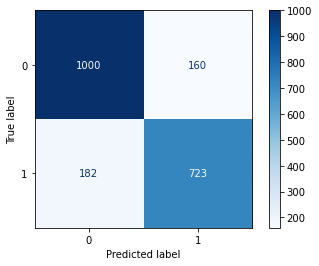

In [71]:
# View confusion matrix
plot_confusion_matrix(svm_cvec, X_test, y_test, cmap='Blues', values_format='d')

### Model evaluations

### Review and compare models score

In [72]:
# create a dataframe to compare the score between models

model_comparison = pd.DataFrame(columns=['model','train_score','test_score','f1_score'])

In [73]:
# list of models
models = [mnb_cvec,
          rf_cvec,
          lr_cvec,
          knn_cvec,
          svm_cvec]

# list of prediction based on different models
y_preds = [predict_mnb, predict_rf, predict_lr, predict_knn, predict_svm]


model_comparison["model"] = [f"{model.estimator.steps[1]}" for model in models]

model_comparison["train_score"] = [round(model.score(X_train, y_train), 4) for model in models]

model_comparison["test_score"] = [round(model.score(X_test, y_test), 4) for model in models]

model_comparison["f1_score"] = [round(f1_score(y_test, pred), 4) for pred in y_preds]


model_comparison

,model,train_score,test_score,f1_score
0,"('mnb', MultinomialNB())",0.9913,0.8247,0.7908
1,"('rf', RandomForestClassifier())",0.9997,0.7709,0.6740
2,"('lr', LogisticRegression())",0.9997,0.8324,0.8073
3,"('knn', KNeighborsClassifier())",0.9997,0.6799,0.4487
4,"('svm', SVC())",0.9997,0.8344,0.8087


**Comments:** We use F1 score as metrics as it is a combination of precison and recall metrics into a single metric. From the table, we can see that most of the models are able to achieve high score on training sets with the helps of hyperparameters tuning. SVM able to achieve highest overall test_score at 0.8344. However the f1_score for SVM model is only 0.7881. The model with the highest f1_score is Multinomial Naive Bayes mode. Randomforest and KNN model has lover test_score at 0.7685 and 0.6799 respectively. This shows that the model was overfitted. 

#### Logistic Regeression Coefficients

In [74]:
features = lr_cvec.best_estimator_[0].get_feature_names()

In [75]:
# create dataframe for features with coef

feature_importance = pd.DataFrame(np.transpose(lr_cvec.best_estimator_[1].coef_),
                         columns=["coef"],
                         index= features)
# sorting for highest coef
feature_importance = feature_importance.sort_values("coef", ascending=False)
feature_importance.head(20)

,coef
content of,2.340086
covid,1.845298
content,1.785421
christmas,1.684689
amp,1.681607
stolen,1.445817
nft,1.381573
omicron,1.327589
say he,1.310572
camel,1.302957


#### Randomforest feature importances

In [76]:
# include Randomforest's feature importance to the dataframe
feature_importance['feature_importances'] = np.transpose(rf_cvec.best_estimator_[1].feature_importances_)
                                                         
# Fileter the features based on Random forest feature importances.   
feature_importance.sort_values("feature_importances", ascending=False).head(20)

,coef,feature_importances
in three,0.108806,0.007236
fare game,0.108863,0.006604
generosity bill,0.103490,0.004858
mississippi case,0.121435,0.004660
re elected,-0.014929,0.003999
too poor,-0.010438,0.003550
who drove,-0.051529,0.003484
celebrates 10th,-0.063033,0.003430
positive marketing,-0.035885,0.003145
expect sex,-0.138964,0.002916


### Show the sentence contain words with highest coefficient form logistic regression

In [77]:
a = feature_importance['coef'][:5].index
reddit_post['title'].apply(lambda x: any(b in x for b in a)) 

indexes= reddit_post[reddit_post['title'].apply(lambda x: any(b in x for b in a))==True].index

for index in indexes:
    print(reddit_post['title'][index], reddit_post['subreddit'][index])

Rock &amp; Roll Hall Of Fame Displays 43 Bullets Ringo Starr Took For John Lennon Before Mark David Chapman Caught Him Off Guard TheOnion
The Taliban try to understand Trans &amp; Women rights TheOnion
New Hampshire, Vermont asked to test deer for COVID-19 TheOnion
World Chess Championship Forced To Use Salt Shaker After Losing Bishop TheOnion
Travis Scott Partners With Stamps.Com In Hope Saving Time And Money On Shipping Also Helps Concertgoers Heal TheOnion
Marlboro Sneaks Back Into Television Advertising With ‘Isn’t It Time We Started Smoking Again?’ Campaign TheOnion
Man Asks If Clinic Has Any Visual Aids He Can Use To Produce Urine Sample TheOnion
Destanis locks down florida after covid vaccination gets out of hand TheOnion
BP Launches Environmental Campaign Pledging To Clean Up Oil Polluting Earth’s Interior TheOnion
Tensions Escalate As Israel Closes Embassy Inside Ben &amp; Jerry’s Factory TheOnion
Potential Gamer Fuel? Dove Men+Care Fresh &amp; Clean Fortifying 2-In-1 Shampoo 

#### Plot most significant coefs from Logistic Regression

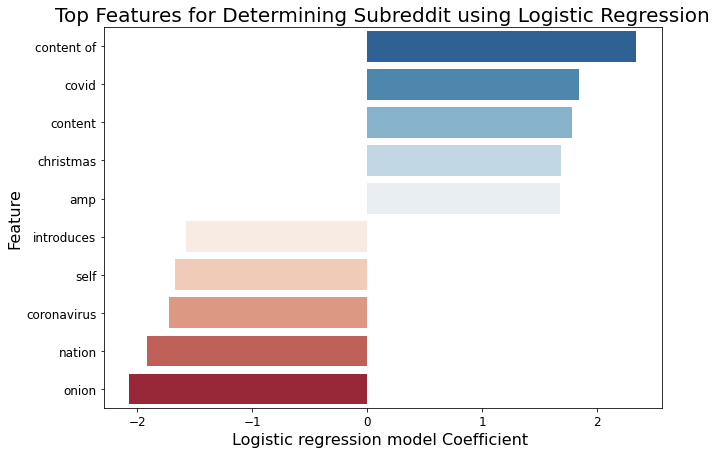

In [78]:
lr_coef = pd.concat(objs=[feature_importance.sort_values("coef", ascending=False).head(), feature_importance.sort_values("coef", ascending=False).tail()])

# plotting most significant coefs from Logistic Regression
plt.figure(figsize=(10, 7))
sns.barplot(data=lr_coef,
            x="coef",
            y=lr_coef.index,
            palette="RdBu_r")
plt.title("Top Features for Determining Subreddit using Logistic Regression", size=20)
plt.yticks(size=12)
plt.xticks(size=12)
plt.ylabel("Feature", size=16)
plt.xlabel("Logistic regression model Coefficient ", size=16);

**Comments:**  Based on the LR model coefficient, we can see the words that affect the model most significantely. We observed that word 'covid' and 'coronavirus' which represent the same meaning however their coefficient are positive and negative at the same time. 

#### Plot most significant coefs from RandomForest

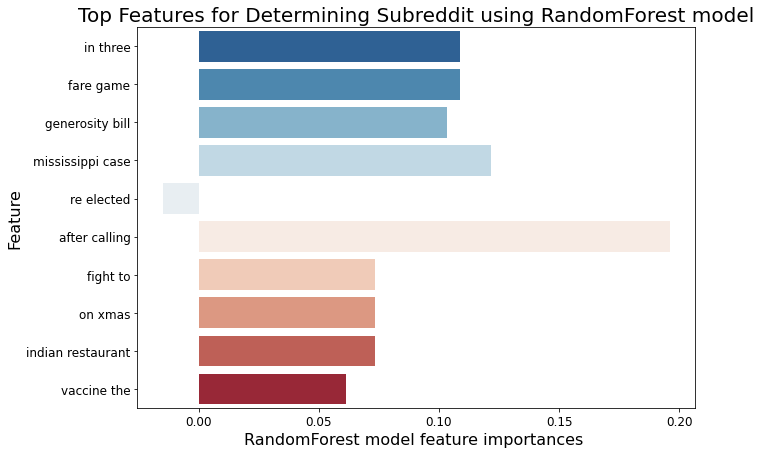

In [79]:
rf_feature_imp = pd.concat(objs=[feature_importance.sort_values("feature_importances", ascending=False).head(), feature_importance.sort_values("feature_importances", ascending=False).tail()])

# plotting most significant coefs
plt.figure(figsize=(10, 7))
sns.barplot(data=rf_feature_imp,
            x="coef",
            y=rf_feature_imp.index,
            palette="RdBu_r")
plt.title("Top Features for Determining Subreddit using RandomForest model", size=20)
plt.yticks(size=12)
plt.xticks(size=12)
plt.ylabel("Feature", size=16)
plt.xlabel("RandomForest model feature importances ", size=16);

**Comments:**  The word 'onion' has the most negative impact to the RandomForest model.

### ROC curve

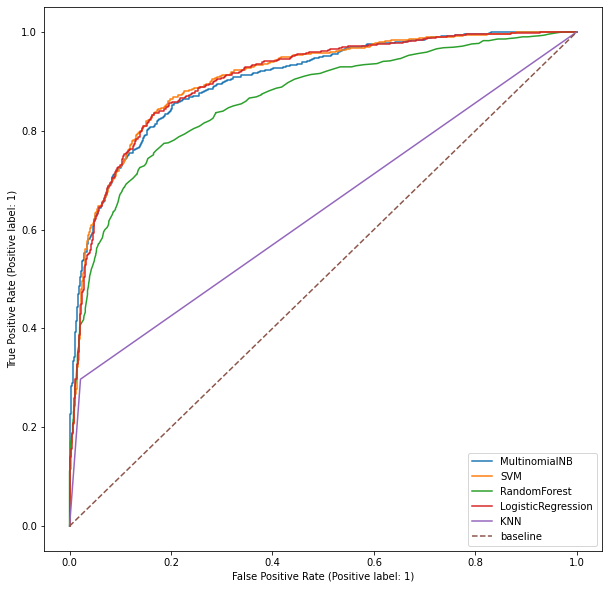

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_roc_curve(mnb_cvec, X_test, y_test, ax=ax, label='MultinomialNB')
plot_roc_curve(svm_cvec, X_test, y_test, ax=ax,label='SVM')
plot_roc_curve(rf_cvec, X_test, y_test, ax=ax, label='RandomForest')
plot_roc_curve(lr_cvec, X_test, y_test, ax=ax, label='LogisticRegression')
plot_roc_curve(knn_cvec, X_test, y_test, ax=ax, label='KNN')
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--') # to simulate random guess 
plt.legend();

In [81]:
roc_auc =[]
    
for pred in y_preds:
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    roc_auc.append(auc(fpr, tpr))
    
roc_auc

[0.8171246904172224,
 0.7455967803391123,
 0.8290007620499142,
 0.6378429224614213,
 0.8304819965707754]

In [82]:
auc_comparison = pd.DataFrame(columns=['model','auc'])

auc_comparison["model"] = [f"{model.estimator.steps[1]}" for model in models]

auc_comparison["auc"] = [auc for auc in roc_auc]

In [83]:
auc_comparison

,model,auc
0,"('mnb', MultinomialNB())",0.817125
1,"('rf', RandomForestClassifier())",0.745597
2,"('lr', LogisticRegression())",0.829001
3,"('knn', KNeighborsClassifier())",0.637843
4,"('svm', SVC())",0.830482


**Comments:**  ROC curve is used to measure the performance of classification model. It explains how much the model is capable of differentiating between classes. The higher the AUC - Area under curve, the better the model is at predicting the results. <br> From the ROC curve, we can see that KNeighborsClassifier is the worst model at predicting the datasets, with only 0.638% area under curve. SVM, LogisticRegression and MultinomialNB are at the top 3 models that excel in predicting the outcome. 

## Conclusions and Recommendations

### Conclusions

We have explore the NLP method to identify fake news and real news. The data collected from r/TheOnion or r/nottheonion has been processed by using methods such as word extration, tokenizing, and lemmatizing. The Support vector machines model(SVM) has the highest test score at 83.44% and F1 scores of 80.87%. LogisticRegression model also performed similarly compared to SVM with test score of 83.23% and F1 scores of 80.73% despite being a simpler model. KNN is the worse model to predict title from r/TheOnion or r/nottheonion with 44.87% f1 score only. The hyperparameter tuning for countvectorizer suggest to include stop word is a better parameter. <br>

Hence, we will choose `CountVectorizer` + `Support vector machines model(SVM)` model as it has the highest F1 scores that minimise false positives and false negatives. Also it is simple and easy to implement in order to provide accurate text classification predictions.



### Recommendations

The model does not include special characters such as emojis, non english words, or any other non alphanumeric characters. There could be some important information being ignored. Further preprocessing could be done on the subreddit title to capture more informations from text. <br> 

Furthermore, we could also try to model with stopword removed. As those common words could appear in both subreddit frequently. Add on more features such as subtext, comments and upvotes can be consider to train the model. We can also experiment with more advanced NLP teahniques such as BERT language model. 

